<a href="https://colab.research.google.com/github/sio-co2o2/keelingcurve_notebooks/blob/main/notebooks/create_graphic_mlo_two_years_keelingcurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a graphic appearing on the Keeling Curve website
### **Graphic: CO<sub>2</sub> record at Mauna Loa, Hawaii for the last 2 years**

#### This notebook creates customizable PDF and PNG images of a graphic appearing on the front page of [https://keelingcurve.ucsd.edu](keelingcurve.ucsd.edu).

See an overview of the Keeling Curve notebooks at [notebooks overview](https://colab.research.google.com/github/sio-co2o2/keelingcurve_notebooks/blob/main/notebooks/overview_of_notebooks_keelingcurve.ipynb)

#### Sample of the graphic produced by this notebook

![title](https://github.com/sio-co2o2/keelingcurve_notebooks/blob/main/images/sample_plots/mlo_two_years.png?raw=1)

## **Notebook Code**

### Import python packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
from matplotlib.path import Path
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import matplotlib.transforms
from matplotlib import animation
from ipywidgets import widgets
from IPython.display import HTML, display
from base64 import b64encode
from PIL import Image
import urllib
import os

%matplotlib inline

In [2]:
# This package is used to convert a vector svg into a png

try:
  from cairosvg import svg2png
except:
  ! pip install cairosvg

In [3]:
# This import is to enable Google Colab to save files ane then download them

# This import does not exist unless the notebook is run in Google Colab
# Put in a try except block if user wants to use notebook off of Google Colab

try:
    from google.colab import files
except:
    pass

### Set directories and file names

In [4]:
# Read in data from github repository
data_file = 'https://raw.githubusercontent.com/sio-co2o2/keelingcurve_notebooks/main/data/mlo/mlo_two_year_span.csv'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/ucsd_sio_logo.svg'

plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_basename = 'mlo_two_years'

pdf_file = plot_dir / f"{plot_basename}.pdf"
png_file = plot_dir / f"{plot_basename}.png"

## **Load in data and prepare it for plotting**

### Load in MLO record

In [5]:
df = pd.read_csv(data_file,sep=',',comment='"')
df.head()

,date_dy,co2_dy,date_wk,co2_wk,date_mn,co2_mn
0,2020.818306,410.92,2020.811475,411.48,2020.874317,412.88
1,2020.821038,411.30,2020.830601,411.75,2020.956284,413.89
2,2020.823770,411.63,2020.849727,412.30,2021.041096,415.15
3,2020.826503,411.61,2020.868852,412.61,2021.126027,416.47
4,2020.829235,411.51,2020.887978,412.91,2021.202740,417.16


### Break into dataframes for each time frequency

In [6]:
df_daily = df[['date_dy', 'co2_dy']].copy()
df_wk = df[['date_wk', 'co2_wk']].copy()
df_mn = df[['date_mn', 'co2_mn']].copy()

### Remove rows with fill values NaN

In [7]:
df_daily = df_daily[df_daily['co2_dy'].notnull()]
df_weekly = df_wk[df_wk['co2_wk'].notnull()]
df_monthly = df_mn[df_mn['co2_mn'].notnull()]

### Convert to numpy arrays for plotting

In [8]:
date_daily = df_daily['date_dy'].to_numpy()
co2_daily = df_daily['co2_dy'].to_numpy()
date_weekly = df_weekly['date_wk'].to_numpy()
co2_weekly = df_weekly['co2_wk'].to_numpy()
date_monthly = df_monthly['date_mn'].to_numpy()
co2_monthly = df_monthly['co2_mn'].to_numpy()

## **Define accessory functions**

## Functions to convert dates into various formats
Used for plot limits and labeling

In [9]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [10]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

In [11]:
#  https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [12]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    print(last_date)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

## Function to create gradient under curve

In [13]:
# https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib
# Modified to add gradient below curve and have a bottom alpha

# def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
def gradient_fill(x, y, fill_color='#FFFFFF', xmin=None, ymin=None, xmax=None, 
                  ymax=None, alpha_bottom=None, ax=None, alpha=1, zorder=1, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    # Only want the gradient to show
    #line, = ax.plot(x, y, **kwargs)
    #if fill_color is None:
    #    fill_color = line.get_color()

    if alpha_bottom is None:
        alpha_bottom = 0

    if xmin is None:
        xmin = x.min()

    if ymin is None:
        ymin = y.min()
        
    if xmax is None:
        xmax = x.max()

    if ymax is None:
        ymax = y.max()
        
    if zorder is None:
        zorder = 1
        
    #zorder = line.get_zorder()
    
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    #z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]
    z[:, :, -1] = np.linspace(alpha_bottom, alpha, 100)[:, None]

    #xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    ax.autoscale(True)
    
    #return line, im

## **Define functions that can modify the graphic**

### Function to set fonts and linewidth properties

In [14]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1.5})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

### Function to set axes properties of the graphic

In [15]:
def set_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel):
    
    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------

    # Allow room at top for the 2 titles
    fig.subplots_adjust(top=0.85)

    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=10, pad=5)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(axis='x', which='major', direction='in', length=6, width=1)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)

    tick_spacing = 5
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels: label.set_fontweight('bold')  

    ax.tick_params(which='minor', direction='in', length=4)
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=18, labelpad=5)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=18, labelpad=5)

    # Set axes limits last 
    # If did before, setting xtick labels past xmin & xmax would have
    # extended the plot limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

### Function to create text tick labels

In [16]:
def create_xtick_labels(ax, xmin, xmax):
 
    # Have ticks at the first of the month and then move the tick label
    # to position at the start of this tick mark

    # Set tick marks to 1st of each month
    start_date = datetime(xmin.year, xmin.month, 1, 0, 0)
    end_date = datetime(xmax.year, xmax.month, 1, 0, 0)

    date_ticks_dt = []
    current=start_date
    while current <= end_date:
        date_ticks_dt.append(current)
        current += relativedelta(months=1)

    date_tick_labels = [x.strftime("%b") for x in date_ticks_dt]

    date_tick_decimal = [dt2t(x) for x in date_ticks_dt]
    
    plt.xticks(date_tick_decimal, date_tick_labels)

    # Move tick labels so left aligned with tick mark
    # to represent the month as starting at the tick mark
    # and not meaning the middle of the month.
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("left")
        
    # Place the starting and ending years below the xaxis tick labels
    start_year = xmin.year
    label_text = start_year    
    ax.annotate(label_text, xy=(0, -0.06), xycoords='axes fraction', fontsize=10,
                horizontalalignment='left', verticalalignment='top', fontweight='bold')

    end_year = xmax.year
    label_text = end_year
    ax.annotate(label_text, xy=(0.97, -0.06), xycoords='axes fraction', fontsize=10,
                horizontalalignment='left', verticalalignment='top', fontweight='bold')

    ax.tick_params(axis='x', pad=7)

### Function to place the titles

In [17]:
def add_plot_title(ax, title1, title2):

    ax.annotate(title1, xy=(0, 1.15), xycoords='axes fraction', fontsize=14,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")
    ax.annotate(title2, xy=(0, 1.07), xycoords='axes fraction', fontsize=18,
                horizontalalignment='left', verticalalignment='top', fontweight = 'bold')

### Function to add an inset label

In [18]:
def add_inset_label(ax, label_start, today):
    label_text = f"{label_start} ending {today}"
    ax.annotate(label_text, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top')

### Function to add legend

In [19]:
def add_legend_labels(ax):

    legend_1 = 'Daily average'
    legend_2 = 'Weekly average'
    legend_3 = 'Monthly average'
    
    legend_properties = {'weight':'bold'}

    black_dot = mlines.Line2D([], [], marker = 'o', color='black',markersize=4, 
             markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, linestyle='None')

    black_filled_circle = mlines.Line2D([], [], marker = 'o', color='black',markersize=5, 
             markerfacecolor='black', markeredgecolor='black', markeredgewidth=1, linestyle='None')

    black_open_circle = mlines.Line2D([], [], marker = 'o', color='black',markersize=7, 
             markerfacecolor='none', markeredgecolor='black', markeredgewidth=1.5, linestyle='None')
    
    # Use best placement for legend
    plt.rc('legend',fontsize=12)
    ax.legend([black_dot, black_filled_circle, black_open_circle], 
              [legend_1, legend_2, legend_3], frameon=False, borderaxespad=1, labelspacing=0.2,
             prop=legend_properties)


### Function to add the SIO logo

In [20]:
def add_sio_logo(fig, logo_file, xpos, ypos):

    # Convert the logo svg file to a png file with the
    # given scale and dpi
    logo_png = 'logo.png'
    svg2png(url=logo_file, write_to=logo_png, scale=10, dpi=300)

    logo = mpimg.imread(logo_png)

    fig.add_axes([xpos, ypos, 0.2, 0.2], anchor='SE', zorder=1)

    plt.imshow(logo)
    plt.axis('off')

    # Delete the logo png version
    os.remove(logo_png)


### Function to save the graphic

In [21]:
def save_graphic(fig, pdf_file, png_file):

    fig_width, fig_height = fig.get_size_inches()

    # For pdf
    width_in = 10
    height_in = (fig_height/fig_width) * width_in

    fig.set_size_inches(width_in, height_in)

    # Save to a high dpi so that logo png file has a high resolution
    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, bbox_inches='tight', dpi=600)

    # For png
    # Want a png of height 500px

    # First save figure as a png and then scale to size needed

    png_dpi = 300

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, bbox_inches='tight')

    # Now resize the image to be width 1000px for the
    # keelingcurve website
    img = Image.open(png_file)
    img_width, img_height = img.size

    # width_px = 1000
    # img_scale = (width_px / img_width)
    # height_px = int((float(img_height) * float(img_scale)))

    height_px = 500
    img_scale = (height_px / img_height)
    width_px = int((float(img_width) * float(img_scale)))

    #img = img.resize((width_px, height_px), Image.Resampling.LANCZOS)
    img = img.resize((width_px, height_px), Image.ANTIALIAS)
    img.save(png_file)


## **Set plot limits and labeling**

### Set titles and axes labels

In [22]:
xlabel = ''
ylabel = "$\mathregular{CO}\\bf{_2}$" + " Concentration (ppm)"

title1 = ''
title2 = 'Carbon dioxide concentration at Mauna Loa Observatory'

### Set yaxis min and max limits

In [23]:
ymin = 405
ymax = 430

### Set xaxis min and max limits

In [24]:
now = datetime.now()
time_ago = now + relativedelta(years=-2)

xmin = time_ago
xmax = now

# Need decimal range for plotting gradiant since
# plotting the gradiant won't work with datetime values
xmin_dt = datetime(year=xmin.year, month=xmin.month, day=xmin.day)
xmin_dec = dt2t(xmin_dt)

xmax_dt = datetime(year=xmax.year, month=xmax.month, day=xmax.day)
xmax_dec = dt2t(xmax_dt)


## **Steps to create the graphic**

### Comment out any function to remove it from the graphic creation

Comment out a line by adding a # symbol in front of a statement


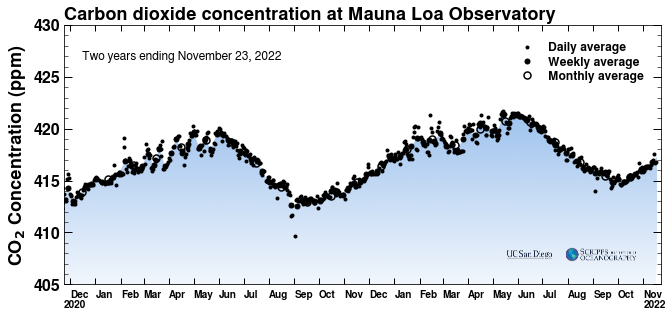

In [25]:
# create a figure container
fig = plt.figure()

# Set axes
# Add padding for exterior plot text
ax = plt.axes([0.11, 0.12, 0.83, 0.54])

# ------------------------------------
# Set properties to use for matplotlib
# ------------------------------------

set_matplotlib_properties()

# ------------------------
# Add gradient under curve
# ------------------------

# The gradient is a guide to the eye
# Extend it to the last data point

max_daily = np.max(date_daily)
max_weekly = np.max(date_weekly)
max_monthly = np.max(date_monthly)
max_date = max(max_daily, max_weekly, max_monthly)

if date_weekly[-1] < max_date:

    # For gradient under all points, evaluate a spline
    # to the weekly values and then evaluate spline to the last
    # daily value
    spline = UnivariateSpline(date_weekly, co2_weekly, s=1) 

    extended_dates = np.linspace(max_weekly + 0.01, xmax_dec, num=10, endpoint=True)
    extended_values = spline(extended_dates)

    x = np.concatenate([date_weekly, extended_dates])
    y = np.concatenate([co2_weekly, extended_values])
else:
    x = date_weekly
    y = co2_weekly

# For gradient max, use last date of data rather than current date
xmax_gradient = max_date

area_color = '#73a7e6'

gradient_fill(x,y, fill_color=area_color, xmin=xmin_dec, ymin=ymin, 
              xmax=xmax_gradient, ymax=ymax, alpha_bottom=0.1, ax=ax, alpha=1.0)


# -------------
# Plot the data
# -------------

# Set plotting zorder above the gradient

ax.plot(date_daily, co2_daily, 'o', color='black',markersize=4, 
         markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, zorder=5)

ax.plot(date_weekly, co2_weekly, 'o', color='black',markersize=5, 
         markerfacecolor='black', markeredgecolor='black', markeredgewidth=1, zorder=6)

ax.plot(date_monthly, co2_monthly, 'o', color='black',markersize=7, 
         markerfacecolor='none', markeredgecolor='black', markeredgewidth=1.5, zorder=7)


# -----------------------------------------------------
# Change xaxis to use date labels and not decimal dates
# -----------------------------------------------------
create_xtick_labels(ax, xmin, xmax)

# -------------------
# Set plot properties
# -------------------
set_plot_props(ax, fig, xmin_dec, xmax_dec, ymin, ymax, xlabel, ylabel)

# ------------------------------------------------
# Get todays date in various formats for labeling
# ------------------------------------------------
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

# ---------------
# Add plot titles
# ---------------
add_plot_title(ax, title1, title2)

# --------------
# Add inset text
# --------------

add_inset_label(ax, 'Two years', todays_date_modyyr)

# ----------------
# Add legend
# ----------------
add_legend_labels(ax)

# --------------------
# Add SIO logo to plot
# --------------------
xpos = 0.715
ypos = 0.155

add_sio_logo(fig, logo_file, xpos, ypos)

# ------------
# Save graphic
# ------------
fig = plt.gcf()

save_graphic(fig, pdf_file, png_file)


plt.show()

## Download Plots (pdf & png)

In [26]:
def download_files(ev):
    files.download(png_file)
    files.download(pdf_file)

button = widgets.Button(description='Download Files', button_style='primary')
button.on_click(download_files)
display(button)

Button(button_style='primary', description='Download Files', style=ButtonStyle())